# Resection delineation

This notebook shows an example workflow to delineate resection on MRI image.
Inputs: Pre-op MRI image, Post-op MRI image
Outputs: Post-op MRI image affinely registered to pre-op MRI image, resection mask

In [1]:
# Import Necessary Libraries
import nilearn.image as ni
from warp_utils import apply_warp
from aligner import Aligner
from monai.transforms import (
    LoadImage,
    Resize,
    EnsureChannelFirst,
    ScaleIntensityRangePercentiles,
)
import nibabel as nib
import os
import os.path
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.morphology import remove_small_objects, opening

from warper import Warper
import nibabel.processing as nibp
from skimage.measure import label

from shutil import copyfile


/home/ajoshi/anaconda3/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/ajoshi/anaconda3/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# Input cell
The following cell is input cell. Make sure that inputs are correct

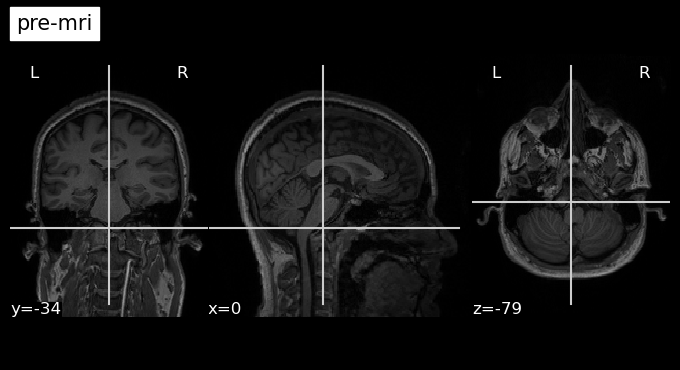

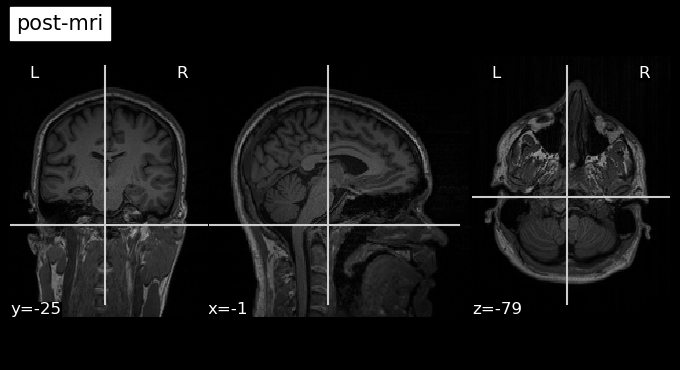

In [2]:

BrainSuitePATH = "/home/ajoshi/BrainSuite23a"
ERR_THR = 80


pre_mri = '/deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/sub-M1998N33-M1998N33_MRI.nii.gz' 
#'/deneb_disk/auto_resection/data_8_4_2023/sub-M1994N4J/sMRI/sub-M1994N4J-M1994N4J_MRI.nii.gz'
post_mri = '/deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/sub-M1998N33-M1998N33_postRS_MRI.nii.gz'
#'/deneb_disk/auto_resection/data_8_4_2023/sub-M1994N4J/sMRI/sub-M1994N4J-M1994N4J_post_RS_MRI.nii.gz'

from nilearn import plotting
import matplotlib.pyplot as plt
import matplotlib


plotting.plot_anat(pre_mri,title='pre-mri')
plotting.plot_anat(post_mri,title='post-mri')

plotting.show()

In [3]:

affine_reg = Aligner()

pre_mri_base_orig = pre_mri[:-7]
post_mri_base_orig = post_mri[:-7]


pth_pre, base_pre = os.path.split(pre_mri_base_orig)
pth_post, base_post = os.path.split(post_mri_base_orig)


Create a temporary directory where intermediate outputs will be stored. Currently it is not deleted, but you can delete this directory later on if you want.

The images are resampled to 1mm cubic voxels

In [4]:

temp_pth = os.path.join(pth_post, 'temp_dir_resection')

print(f'Temporary files will be stored in {temp_pth}')

if not os.path.isdir(temp_pth):
    os.makedirs(temp_pth)


pre_mri_base = os.path.join(temp_pth, base_pre+'_1mm')
post_mri_base = os.path.join(temp_pth, base_post+'_1mm')

out_img = nibp.conform(nib.load(pre_mri_base_orig+'.nii.gz'))
out_img.to_filename(pre_mri_base + '.nii.gz')

out_img = nibp.conform(nib.load(post_mri_base_orig+'.nii.gz'))
out_img.to_filename(post_mri_base + '.nii.gz')


pre_mri_dir, _ = os.path.split(pre_mri_base)


mov_img_orig = post_mri_base + ".nii.gz"

# If the nii.gz file does not exist then maybe .nii file exist. Check your input

if not os.path.isfile(mov_img_orig):
    mov_img_orig = post_mri_base + ".nii"


Temporary files will be stored in /deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/temp_dir_resection


In [5]:

cmd = (
    os.path.join(BrainSuitePATH, "bin", "bse")
    + " -i "
    + pre_mri_base + '.nii.gz'
    + " -o "
    + pre_mri_base + '.bse.nii.gz'
    + " --auto --trim --mask "
    + pre_mri_base + '.mask.nii.gz'
)
os.system(cmd)

cmd = (
    os.path.join(BrainSuitePATH, "bin", "bfc")
    + " -i "
    + pre_mri_base + '.bse.nii.gz'
    + " -o "
    + pre_mri_base + '.bfc.nii.gz'
    + " -m "
    + pre_mri_base + '.mask.nii.gz'
)
os.system(cmd)


cmd = (
    os.path.join(BrainSuitePATH, "bin", "pvc")
    + " -i "
    + pre_mri_base + '.bfc.nii.gz'
    + " -o "
    + pre_mri_base + '.pvc.label.nii.gz'
    + " -f "
    + pre_mri_base + '.pvc.frac.nii.gz'
)
os.system(cmd)


# Post MRI pre processing


cmd = (
    os.path.join(BrainSuitePATH, "bin", "bse")
    + " -i "
    + post_mri_base + '.nii.gz'
    + " -o "
    + post_mri_base + '.bse.nii.gz'
    + " --auto --trim --mask "
    + post_mri_base + '.mask.nii.gz'
)
os.system(cmd)

cmd = (
    os.path.join(BrainSuitePATH, "bin", "bfc")
    + " -i "
    + post_mri_base + '.bse.nii.gz'
    + " -o "
    + post_mri_base + '.bfc.nii.gz'
    + " -m "
    + post_mri_base + '.mask.nii.gz'
)
os.system(cmd)


cmd = (
    os.path.join(BrainSuitePATH, "bin", "pvc")
    + " -i "
    + post_mri_base + '.bfc.nii.gz'
    + " -o "
    + post_mri_base + '.pvc.label.nii.gz'
    + " -f "
    + post_mri_base + '.pvc.frac.nii.gz'
)
os.system(cmd)



sh: 1: /home/ajoshi/BrainSuite23a/bin/bse: not found
sh: 1: /home/ajoshi/BrainSuite23a/bin/bfc: not found
sh: 1: /home/ajoshi/BrainSuite23a/bin/pvc: not found
sh: 1: /home/ajoshi/BrainSuite23a/bin/bse: not found
sh: 1: /home/ajoshi/BrainSuite23a/bin/bfc: not found
sh: 1: /home/ajoshi/BrainSuite23a/bin/pvc: not found


32512

# Do Affine Registration of post-op MRI to pre-op MRI

The following code uses CNN to register pos-top mri to pre-op mri

In [6]:

mov_img = post_mri_base + ".pvc.frac.nii.gz"
ref_img = pre_mri_base + ".pvc.frac.nii.gz"
ref_img_mask = pre_mri_base + ".mask.nii.gz"
ref_img_pvc_frac = pre_mri_base + ".pvc.frac.nii.gz"
error_img = pre_mri_dir + "/error_pre_post.nii.gz"
error_mask_img = pre_mri_dir + "/error_pre_post.mask.nii.gz"
error_init_mask_img = pre_mri_dir + "/error_pre_post.init.mask.nii.gz"


# rigidly warped image
affine_reg_img = pre_mri_dir + "/post2pre.nii.gz"
affine_reg_img_bse = pre_mri_dir + "/post2pre.bse.nii.gz"
affine_reg_img_mask = pre_mri_dir + "/post2pre.mask.nii.gz"
affine_reg_img_bfc = pre_mri_dir + "/post2pre.bfc.nii.gz"
affine_reg_img_pvc_label = pre_mri_dir + "/post2pre.pvc.label.nii.gz"
affine_reg_img_pvc_frac = pre_mri_dir + "/post2pre.pvc.frac.nii.gz"

ddf = pre_mri_dir + "/ddf.nii.gz"


affine_reg.affine_reg(
    fixed_file=ref_img,
    moving_file=mov_img,
    output_file=affine_reg_img_bse,
    ddf_file=ddf,
    loss="cc",
    nn_input_size=64,
    lr=1e-6,
    max_epochs=1500,
    device="cuda",
)


moving, moving_meta = LoadImage()(mov_img_orig)
moving = EnsureChannelFirst()(moving)

target, _ = LoadImage()(ref_img)
target = EnsureChannelFirst()(target)


image_movedo = apply_warp(affine_reg.ddf[None,], moving[None,], target[None,])

nib.save(
    nib.Nifti1Image(image_movedo[0, 0].detach(
    ).cpu().numpy(), affine_reg.target.affine),
    affine_reg_img,
)



/home/ajoshi/anaconda3/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.array LoadImage.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


/home/ajoshi/anaconda3/lib/python3.11/site-packages/monai/networks/blocks/warp.py:67: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


/home/ajoshi/anaconda3/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.array LoadImage.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


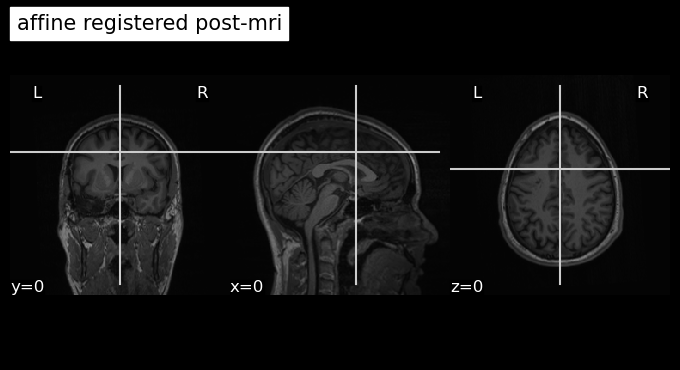

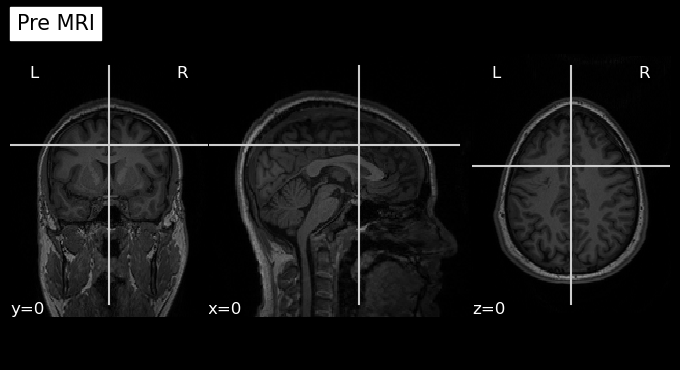

In [7]:
from nilearn import plotting
import matplotlib.pyplot as plt
import matplotlib


plotting.plot_anat(affine_reg_img, title="affine registered post-mri",cut_coords=(0,0,0))
plotting.plot_anat(pre_mri, title="Pre MRI",cut_coords=(0,0,0))
plotting.show()

In [8]:

cmd = (
    os.path.join(BrainSuitePATH, "bin", "bse")
    + " -i "
    + affine_reg_img
    + " -o "
    + affine_reg_img_bse
    + " --auto --trim --mask "
    + affine_reg_img_mask
)
os.system(cmd)

cmd = (
    os.path.join(BrainSuitePATH, "bin", "bfc")
    + " -i "
    + affine_reg_img_bse
    + " -o "
    + affine_reg_img_bfc
    + " -m "
    + affine_reg_img_mask
)
os.system(cmd)


cmd = (
    os.path.join(BrainSuitePATH, "bin", "pvc")
    + " -i "
    + affine_reg_img_bfc
    + " -o "
    + affine_reg_img_pvc_label
    + " -f "
    + affine_reg_img_pvc_frac
)
os.system(cmd)


sh: 1: /home/ajoshi/BrainSuite23a/bin/bse: not found
sh: 1: /home/ajoshi/BrainSuite23a/bin/bfc: not found
sh: 1: /home/ajoshi/BrainSuite23a/bin/pvc: not found


32512

Apply Afiine registrations to the images and find initial estimate of don't care region

In [9]:

# Load the images and normalize their intensities
vref, _ = LoadImage()(ref_img_pvc_frac)
vwrp, _ = LoadImage()(affine_reg_img_pvc_frac)
msk, _ = LoadImage()(ref_img_mask)

vwrp = (255.0 / np.max(vwrp[msk > 0])) * vwrp
vref = (255.0 / np.max(vref[msk > 0])) * vref


# compute the error and smooth the error
vwrp = np.sqrt((vref - vwrp) ** 2)
vwrp = vwrp * (msk > 0)
vwrp = gaussian_filter(vwrp, sigma=1)

nib.save(nib.Nifti1Image(vwrp, affine_reg.target.affine), error_img)

error_mask = opening(vwrp > ERR_THR)
nib.save(
    nib.Nifti1Image(255 * np.uint8(error_mask), affine_reg.target.affine),
    error_init_mask_img,
)


resection_mask = remove_small_objects(error_mask)
nib.save(
    nib.Nifti1Image(255 * np.uint8(resection_mask), affine_reg.target.affine),
    error_mask_img,
)


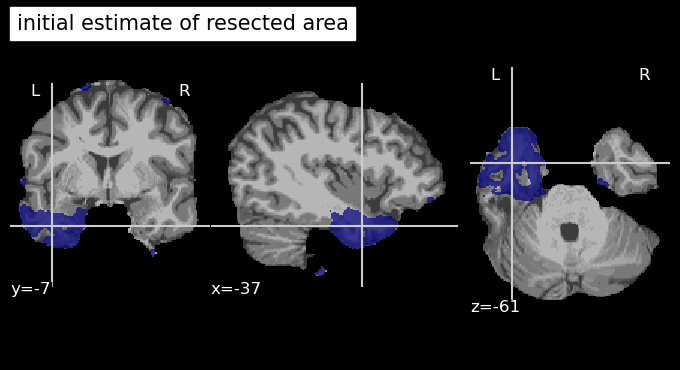

In [10]:
plotting.plot_roi(roi_img=error_mask_img, bg_img=ref_img_pvc_frac, title="initial estimate of resected area")


In [11]:

nonlin_reg = Warper()

ref_img_bfc = pre_mri_base + ".bfc.nii.gz"

error_img = pre_mri_dir + "/error_pre_post.nonlin.nii.gz"

error_init_mask_img = pre_mri_dir + "/error_pre_post.nonlin.init.mask.nii.gz"

error_mask_img_nonlin = pre_mri_dir + "/error_pre_post.nonlin.mask.nii.gz"


error_mask_img_rigid = pre_mri_dir + "/error_pre_post.init.mask.nii.gz"

target_msk_file = pre_mri_dir + "/target.mask.nii.gz"

# rigidly warped image

nonlin_reg_img_pvc_frac = pre_mri_dir + \
    "/post2pre.nonlin.warped.pvc.frac.nii.gz"

jac_file = pre_mri_dir + "/jacobian.nii.gz"


ddf = pre_mri_dir + "/ddf_nonlin.nii.gz"


tar_msk, target_mask_meta = LoadImage()(error_mask_img_rigid)
tar_msk = gaussian_filter(tar_msk, sigma=1)
tar_msk = np.float32(tar_msk < 1)

nib.save(
    nib.Nifti1Image(255 * (tar_msk), target_mask_meta["affine"]),
    target_msk_file,
)


# Do Non-linear transformation
The following code uses CNN to do nonlinear registration

In [12]:

nonlin_reg.nonlinear_reg(
    target_file=ref_img_pvc_frac,
    moving_file=affine_reg_img_pvc_frac,
    output_file=nonlin_reg_img_pvc_frac,
    ddf_file=ddf,
    reg_penalty=3,
    nn_input_size=64,
    lr=1e-3,
    max_epochs=1000,
    loss="mse",
    jacobian_determinant_file=jac_file,
    target_mask=target_msk_file,
)


/home/ajoshi/anaconda3/lib/python3.11/site-packages/monai/networks/blocks/warp.py:67: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


optimizing
finished  1000  epochs3m 0.05  



computing deformation field
applying warp
saving warped output: /deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/temp_dir_resection/post2pre.nonlin.warped.pvc.frac.nii.gz
saving ddf: /deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/temp_dir_resection/ddf_nonlin.nii.gz


In [13]:

vref, _ = LoadImage()(ref_img_pvc_frac)
vwrp, _ = LoadImage()(nonlin_reg_img_pvc_frac)
msk, _ = LoadImage()(ref_img_mask)


print(ref_img_pvc_frac)
print(nonlin_reg_img_pvc_frac)
print(ref_img_mask)


/deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/temp_dir_resection/sub-M1998N33-M1998N33_MRI_1mm.pvc.frac.nii.gz
/deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/temp_dir_resection/post2pre.nonlin.warped.pvc.frac.nii.gz
/deneb_disk/auto_resection/data_8_4_2023/sub-M1998N33/sMRI/temp_dir_resection/sub-M1998N33-M1998N33_MRI_1mm.mask.nii.gz


In [14]:
def getLargestCC(segmentation):
    labels = label(segmentation)
    assert(labels.max() != 0)  # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC


In [15]:


vwrp = vref - vwrp


nib.save(nib.Nifti1Image(vwrp.detach().numpy(),
         nonlin_reg.target.affine), error_img)
vwrp = vwrp * (msk > 0)

ST = 3
ERR_THR = 0.99
error_mask = opening(vwrp > ERR_THR, footprint=[
                     (np.ones((ST, 1, 1)), 1), (np.ones((1, ST, 1)), 1), (np.ones((1, 1, ST)), 1)])
nib.save(
    nib.Nifti1Image(255 * np.uint8(error_mask), nonlin_reg.target.affine),
    error_init_mask_img,
)

resection_mask = remove_small_objects(error_mask)
resection_mask = getLargestCC(resection_mask)

nib.save(
    nib.Nifti1Image(255 * np.uint8(resection_mask), nonlin_reg.target.affine),
    error_mask_img_nonlin,
)


Write Mask to pre_image space

In [16]:
output_mask_pre = pre_mri_base_orig + '.resection.mask.nii.gz'
output_mask_post = post_mri_base_orig + '.resection.mask.nii.gz'

affine_reg_img_out = pre_mri_base_orig + '.affine.post2pre.nii.gz'
copyfile(affine_reg_img, affine_reg_img_out)

ni.resample_to_img(error_mask_img_nonlin, pre_mri,
                   interpolation='nearest').to_filename(output_mask_pre)


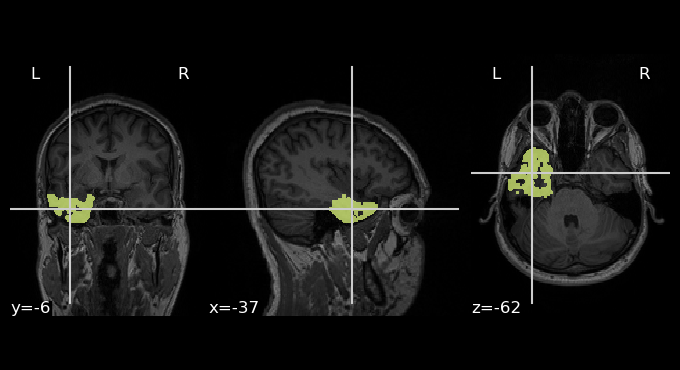

In [17]:
plotting.plot_roi(output_mask_pre,bg_img=pre_mri,cmap='Wistia')